In [2]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import *
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent

def caluclate_cpm_from_bootstrapping(file_path):
    metrics = pd.read_csv(file_path)

    fps = metrics['FPrate']
    mean_sens = metrics['Sensivity[Mean]']
    low_mean_sens = metrics['Sensivity[Lower bound]']
    high_mean_sens = metrics['Sensivity[Upper bound]']

    idxs = []
    for fps_value in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
        idxs.append(np.abs(fps - fps_value).argmin())
        
    fps = fps[idxs]
    mean_sens = mean_sens[idxs]
    low_sens = low_mean_sens[idxs]
    high_sens = high_mean_sens[idxs]

    
    df = pd.DataFrame({'fps': fps, 'mean_sens': mean_sens, 'low_sens': low_sens, 'high_sens': high_sens}).apply(lambda x: np.round(x,2))
    mean_cpm = df['mean_sens'].mean()
    low_cpm = df['low_sens'].mean()
    high_cpm = df['high_sens'].mean()

    display(df)
    print('Mean Sensitivity:', np.round(mean_cpm,2), 'Low Sensitivity:', np.round(low_cpm,2), 'High Sensitivity:', np.round(high_cpm,2))

def show_metrics(file_path):
    metrics = pd.read_csv(file_path, skiprows=6, sep=':').rename(columns={0:'Metric',1:'Value'}).round(3)
    display(metrics)

# GRT123 - Trained & Eval SUMMIT

In [44]:
# Add in diameter cuts for later analysis
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv')
annotations['diameter_cats'] = pd.cut(
    annotations['diameter_mm'],
    bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 999],
    labels=['1. 0-5', '2. 5-10', '3. 10-15', '4. 15-20', '5. 20-25', '6. 25-30', '7. 30-35', '8. 35-40', '9. 40+']
)

# save back to the metadata file
annotations.to_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv', index=False)

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:21<00:00, 45.95it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.15,0.13,0.19
159,0.25,0.22,0.19,0.25
476,0.50,0.31,0.28,0.34
1111,1.00,0.41,0.38,0.44
2381,2.00,0.54,0.50,0.58
4920,4.00,0.70,0.67,0.73
9999,8.00,0.83,0.80,0.86


Mean Sensitivity: 0.45 Low Sensitivity: 0.42 High Sensitivity: 0.48


,True positives,995
0,False positives,26867.000
1,False negatives,121.000
2,True negatives,0.000
3,Total number of candidates,27884.000
4,Total number of nodules,1116.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,24.000
7,Sensitivity,0.892
8,Average number of candidates per scan,31.260


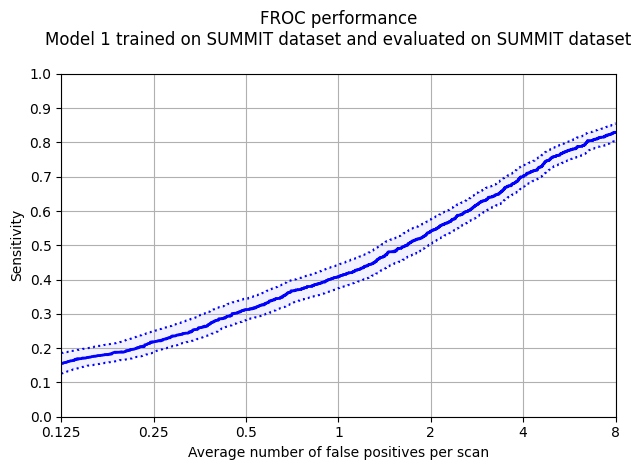

In [3]:

grt123_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv",    
    filter='\nModel 1 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/partial',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/partial/froc_partial_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/partial/CADAnalysis.txt')

## Gender Analysis 

/tmp/tmpmbkgff_e/annotations.csv
Total number of included nodule annotations: 456
Total number of nodule annotations: 456
Cases: 362


100%|██████████| 1000/1000 [00:06<00:00, 157.83it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.13,0.21
159,0.25,0.25,0.19,0.30
476,0.50,0.33,0.28,0.38
1111,1.00,0.43,0.38,0.49
2381,2.00,0.57,0.51,0.63
4920,4.00,0.71,0.66,0.76
9999,8.00,0.83,0.79,0.87


Mean Sensitivity: 0.47 Low Sensitivity: 0.42 High Sensitivity: 0.52


,True positives,401
0,False positives,9454.000
1,False negatives,55.000
2,True negatives,0.000
3,Total number of candidates,9863.000
4,Total number of nodules,456.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,8.000
7,Sensitivity,0.879
8,Average number of candidates per scan,27.246


/tmp/tmpemb9x0va/annotations.csv
Total number of included nodule annotations: 660
Total number of nodule annotations: 660
Cases: 531
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:11<00:00, 84.74it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.15,0.10,0.19
159,0.25,0.21,0.17,0.25
476,0.50,0.30,0.25,0.34
1111,1.00,0.40,0.35,0.45
2381,2.00,0.53,0.48,0.58
4920,4.00,0.69,0.65,0.74
9999,8.00,0.83,0.80,0.86


Mean Sensitivity: 0.44 Low Sensitivity: 0.4 High Sensitivity: 0.49


,True positives,594
0,False positives,17413.000
1,False negatives,66.000
2,True negatives,0.000
3,Total number of candidates,18021.000
4,Total number of nodules,660.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,16.000
7,Sensitivity,0.900
8,Average number of candidates per scan,33.938


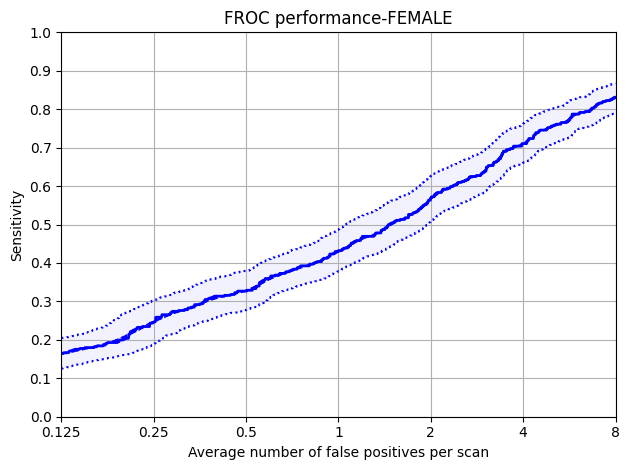

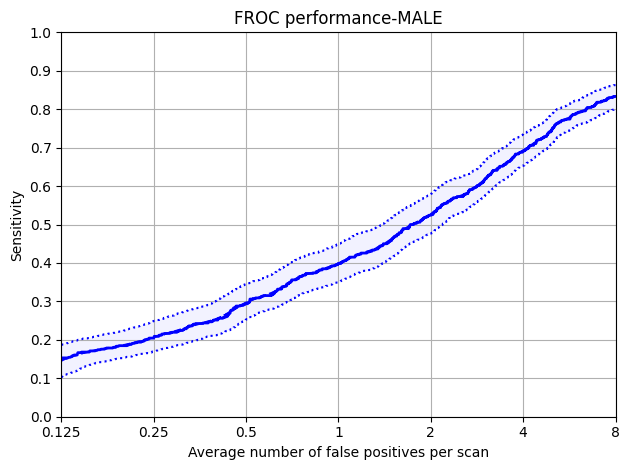

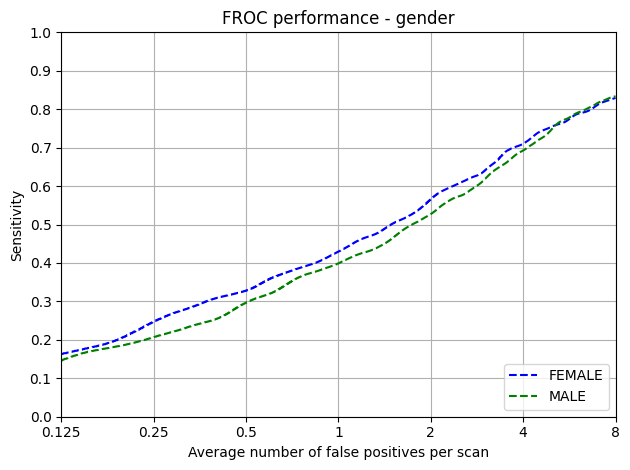

In [4]:
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter

def protected_group_analysis(protected_group, scan_metadata, annotations, exclusions, predictions, output_path):

    output_path = Path(output_path)

    analysis_dict = {}

    for cat in scan_metadata[protected_group].unique():
        with TemporaryDirectory() as temp_dir:
            temp_dir = Path(temp_dir)
            temp_scans = scan_metadata[scan_metadata[protected_group] == cat]['name']
            temp_annotations = annotations[annotations['name'].isin(temp_scans.values)]
            temp_exclusions = exclusions[exclusions['name'].isin(temp_scans.values)]
            temp_predictions = predictions[predictions['name'].isin(temp_scans.values)]

            temp_scans.to_csv(temp_dir / 'scans.csv', index=False)
            temp_annotations.to_csv(temp_dir / 'annotations.csv', index=False)
            temp_exclusions.to_csv(temp_dir / 'exclusions.csv', index=False)
            temp_predictions.to_csv(temp_dir / 'predictions.csv', index=False)

            result = noduleCADEvaluation(
                annotations_filename=temp_dir / 'annotations.csv',
                annotations_excluded_filename=temp_dir / 'exclusions.csv',
                seriesuids_filename=temp_dir / 'scans.csv',
                results_filename=temp_dir / 'predictions.csv',
                filter=f'-{cat}',
                outputDir=output_path / cat,
            )

            caluclate_cpm_from_bootstrapping(output_path / cat / 'froc_predictions_bootstrapping.csv')
            show_metrics(output_path / cat / 'CADAnalysis.txt')

            analysis_dict[cat] = (
                pd.read_csv(output_path / cat / 'froc_predictions_bootstrapping.csv')
                .rename(columns={
                    'FPrate': 'FPRate',
                    'Sensivity[Mean]': 'Sensitivity',
                    'Sensivity[Lower bound]': 'LowSensitivity',
                    'Sensivity[Upper bound]': 'HighSensitivity'
                })
            )

    fig1 = plt.figure()
    ax = plt.gca()
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for idx, cat in enumerate(analysis_dict.keys()):

        metrics = analysis_dict[cat]        
        plt.plot(metrics['FPRate'], metrics['Sensitivity'], ls='--', color=colors[idx],label=cat)
        # plt.plot(metrics['FPRate'], metrics['LowSensitivity'], ls=':', color=colors[idx])
        # plt.plot(metrics['FPRate'], metrics['HighSensitivity'], ls=':', color=colors[idx])
        # ax.fill_between(metrics['FPRate'], metrics['LowSensitivity'], metrics['HighSensitivity'], alpha=0.05)

    xmin = 0.125
    xmax = 8
    plt.xlim(xmin, xmax)
    plt.ylim(0, 1)
    plt.xlabel('Average number of false positives per scan')
    plt.ylabel('Sensitivity')
    #plt.legend(loc='lower right')
    plt.title(f'FROC performance - {protected_group}')
    plt.xscale('log', base=2)
    ax.xaxis.set_major_formatter(FixedFormatter([0.125,0.25,0.5,1,2,4,8]))

    # set your ticks manually
    ax.xaxis.set_ticks([0.125,0.25,0.5,1,2,4,8])
    ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    plt.legend(loc='lower right')
    plt.grid(visible=True, which='both')
    plt.tight_layout()

scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
)

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

## Ethnicity Analysis

/tmp/tmpe98_ucq8/annotations.csv
Total number of included nodule annotations: 18
Total number of nodule annotations: 18
Cases: 21


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1638.49it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.19,0.00,0.50
159,0.25,0.23,0.00,0.55
476,0.50,0.25,0.00,0.59
1111,1.00,0.39,0.10,0.69
2381,2.00,0.52,0.22,0.88
4920,4.00,0.83,0.67,1.00
9999,8.00,0.97,0.86,1.00


Mean Sensitivity: 0.48 Low Sensitivity: 0.26 High Sensitivity: 0.74


,True positives,18
0,False positives,625.000
1,False negatives,0.000
2,True negatives,0.000
3,Total number of candidates,644.000
4,Total number of nodules,18.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,1.000
7,Sensitivity,1.000
8,Average number of candidates per scan,30.667


/tmp/tmp3ht6vbxr/annotations.csv
Total number of included nodule annotations: 852
Total number of nodule annotations: 852
Cases: 660
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: 328
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-7465-gny_Y0_BASELINE_A, nodule Annot ID: 718


100%|██████████| 1000/1000 [00:14<00:00, 67.51it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.15,0.12,0.18
159,0.25,0.22,0.18,0.25
476,0.50,0.32,0.28,0.36
1111,1.00,0.41,0.37,0.45
2381,2.00,0.53,0.49,0.57
4920,4.00,0.69,0.66,0.73
9999,8.00,0.82,0.79,0.85


Mean Sensitivity: 0.45 Low Sensitivity: 0.41 High Sensitivity: 0.48


,True positives,752
0,False positives,20447.000
1,False negatives,100.000
2,True negatives,0.000
3,Total number of candidates,21211.000
4,Total number of nodules,852.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,14.000
7,Sensitivity,0.883
8,Average number of candidates per scan,32.138


/tmp/tmpitgihwvr/annotations.csv
Total number of included nodule annotations: 71
Total number of nodule annotations: 71
Cases: 66


100%|██████████| 1000/1000 [00:01<00:00, 763.49it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.11,0.03,0.25
159,0.25,0.16,0.06,0.33
476,0.50,0.30,0.17,0.49
1111,1.00,0.40,0.25,0.61
2381,2.00,0.58,0.40,0.79
4920,4.00,0.75,0.59,0.93
9999,8.00,0.87,0.76,0.96


Mean Sensitivity: 0.45 Low Sensitivity: 0.32 High Sensitivity: 0.62


,True positives,64
0,False positives,1897.000
1,False negatives,7.000
2,True negatives,0.000
3,Total number of candidates,1962.000
4,Total number of nodules,71.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,1.000
7,Sensitivity,0.901
8,Average number of candidates per scan,29.727


/tmp/tmph7e8gg2r/annotations.csv
Total number of included nodule annotations: 147
Total number of nodule annotations: 147
Cases: 117


100%|██████████| 1000/1000 [00:02<00:00, 487.88it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.05,0.26
159,0.25,0.23,0.14,0.33
476,0.50,0.33,0.25,0.43
1111,1.00,0.42,0.33,0.53
2381,2.00,0.55,0.46,0.66
4920,4.00,0.77,0.69,0.85
9999,8.00,0.90,0.86,0.95


Mean Sensitivity: 0.48 Low Sensitivity: 0.4 High Sensitivity: 0.57


,True positives,138
0,False positives,3045.000
1,False negatives,9.000
2,True negatives,0.000
3,Total number of candidates,3191.000
4,Total number of nodules,147.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,8.000
7,Sensitivity,0.939
8,Average number of candidates per scan,27.274


/tmp/tmp159yasrk/annotations.csv
Total number of included nodule annotations: 28
Total number of nodule annotations: 28
Cases: 32


100%|██████████| 1000/1000 [00:00<00:00, 1374.15it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.26,0.06,0.49
159,0.25,0.31,0.07,0.56
476,0.50,0.39,0.14,0.67
1111,1.00,0.59,0.38,0.82
2381,2.00,0.63,0.45,0.83
4920,4.00,0.80,0.62,1.00
9999,8.00,0.83,0.69,1.00


Mean Sensitivity: 0.54 Low Sensitivity: 0.34 High Sensitivity: 0.77


,True positives,23
0,False positives,853.000
1,False negatives,5.000
2,True negatives,0.000
3,Total number of candidates,876.000
4,Total number of nodules,28.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,0.000
7,Sensitivity,0.821
8,Average number of candidates per scan,27.375


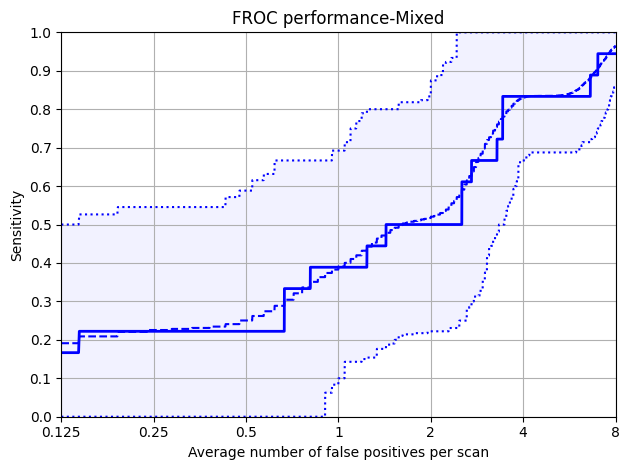

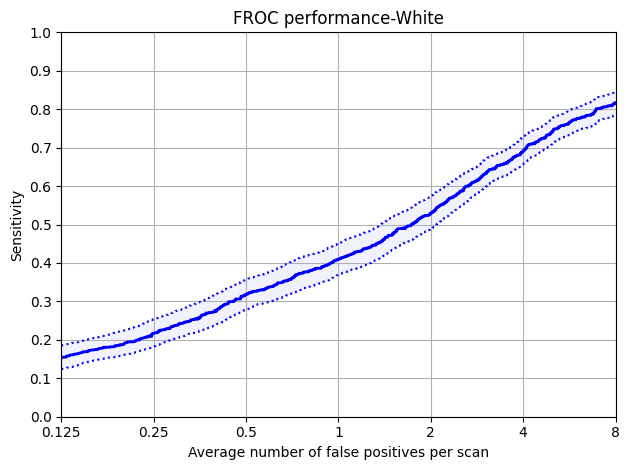

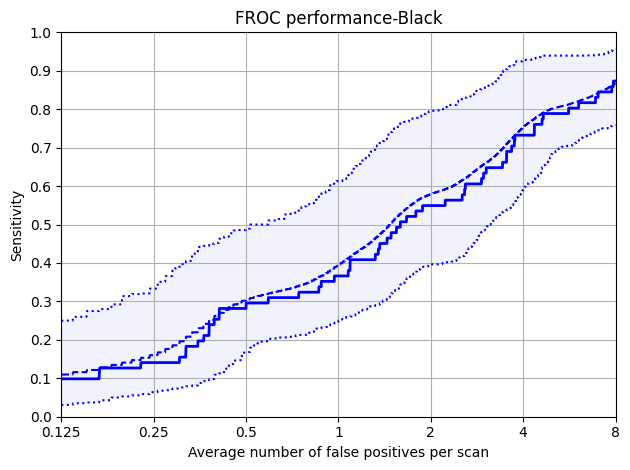

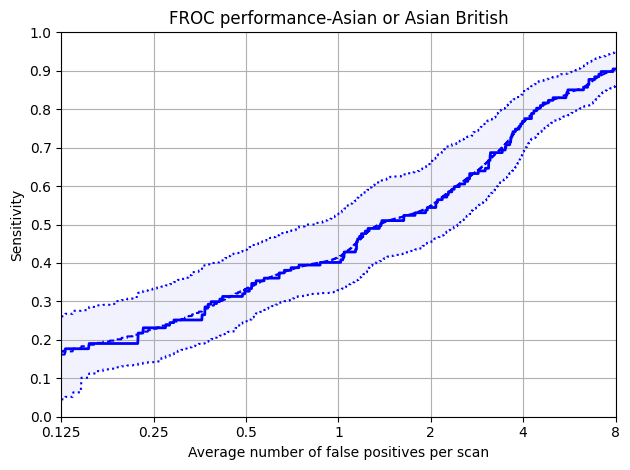

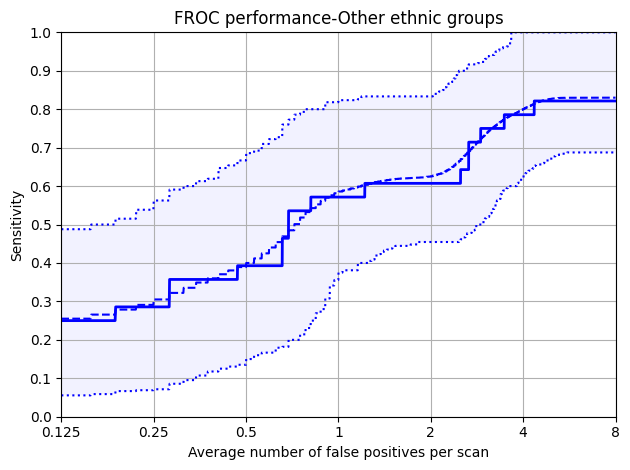

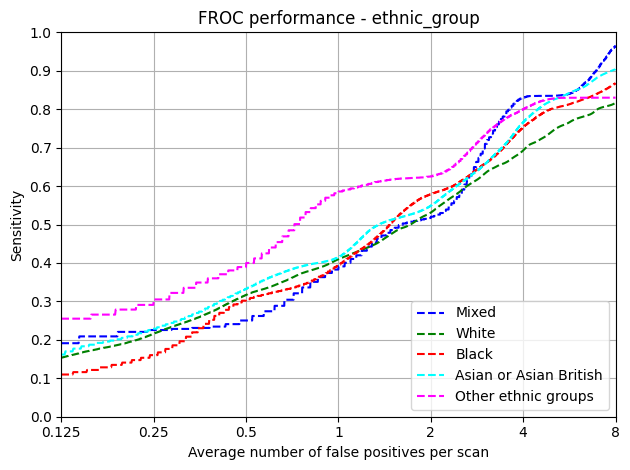

In [5]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

# MONAI Detection - Trained & Eval on SUMMIT

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/partial.json
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/annotations.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodul

100%|██████████| 1000/1000 [00:35<00:00, 28.23it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.13,0.19
159,0.25,0.25,0.21,0.30
476,0.50,0.38,0.34,0.43
1111,1.00,0.54,0.49,0.59
2381,2.00,0.67,0.63,0.72
4920,4.00,0.76,0.71,0.80
9999,8.00,0.81,0.76,0.85


Mean Sensitivity: 0.51 Low Sensitivity: 0.47 High Sensitivity: 0.55


,True positives,944
0,False positives,44062.000
1,False negatives,172.000
2,True negatives,0.000
3,Total number of candidates,45995.000
4,Total number of nodules,1116.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,999.000
7,Sensitivity,0.846
8,Average number of candidates per scan,51.564


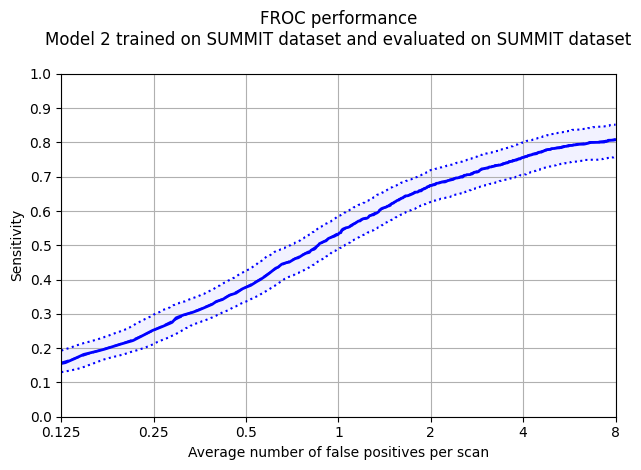

In [6]:
from json import detect_encoding


def combine_predictions(predictions_json_path, dataset_name, use_nms=True):
    """
    Get predictions from a json file

    Args:
    predictions_json_path: str, path to the json file

    Returns:
    images: list of str, list of image names
    predictions: pd.DataFrame, dataframe of predictions
    
    """
    predictions_json_path = Path(predictions_json_path)

    predictions_list = []

    for prediction_json_path in predictions_json_path.glob('*json'):
        
        print(prediction_json_path)

        with open(prediction_json_path,'r') as f:
            predictions_json = json.load(f)

        idx = 0
        for image_cnt, image in enumerate(predictions_json[dataset_name]):
            name = image['image'].split('/')[-1][:-7]
            
            image_predictions_dict = {}
            for box, score in zip(image['box'], image['score']):
                prediction = {}
                prediction['threshold'] = score
                prediction['index'] = box[2]
                prediction['col'] = box[1]
                prediction['row'] = box[0]
                prediction['diameter'] = np.max(box[3:])
                prediction['name'] = name

                image_predictions_dict[idx] = prediction
                idx+=1
            
            image_predictions = pd.DataFrame.from_dict(image_predictions_dict, orient='index')
            predictions_list.append(image_predictions)

    predictions = pd.concat(predictions_list, ignore_index=True)
    predictions.to_csv(predictions_json_path / 'predictions.csv', index=False)

    return predictions_json_path / 'predictions.csv'

predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit', 'test')
predictions = pd.read_csv(predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    results_filename=predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/partial',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/partial/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/partial/CADAnalysis.txt')



## Gender analysis

/tmp/tmpk76udv94/annotations.csv
Total number of included nodule annotations: 456
Total number of nodule annotations: 456
Cases: 362


100%|██████████| 1000/1000 [00:10<00:00, 93.46it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.15,0.10,0.20
159,0.25,0.25,0.19,0.32
476,0.50,0.38,0.31,0.46
1111,1.00,0.52,0.44,0.60
2381,2.00,0.64,0.56,0.72
4920,4.00,0.70,0.62,0.78
9999,8.00,0.76,0.66,0.84


Mean Sensitivity: 0.49 Low Sensitivity: 0.41 High Sensitivity: 0.56


,True positives,361
0,False positives,17563.000
1,False negatives,95.000
2,True negatives,0.000
3,Total number of candidates,18323.000
4,Total number of nodules,456.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,399.000
7,Sensitivity,0.792
8,Average number of candidates per scan,50.616


/tmp/tmpk8i2dkdk/annotations.csv
Total number of included nodule annotations: 660
Total number of nodule annotations: 660
Cases: 531
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlappi

100%|██████████| 1000/1000 [00:17<00:00, 57.70it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.17,0.13,0.21
159,0.25,0.25,0.20,0.31
476,0.50,0.38,0.33,0.44
1111,1.00,0.55,0.49,0.61
2381,2.00,0.70,0.65,0.74
4920,4.00,0.80,0.75,0.84
9999,8.00,0.85,0.81,0.88


Mean Sensitivity: 0.53 Low Sensitivity: 0.48 High Sensitivity: 0.58


,True positives,583
0,False positives,26499.000
1,False negatives,77.000
2,True negatives,0.000
3,Total number of candidates,27672.000
4,Total number of nodules,660.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,600.000
7,Sensitivity,0.883
8,Average number of candidates per scan,52.113


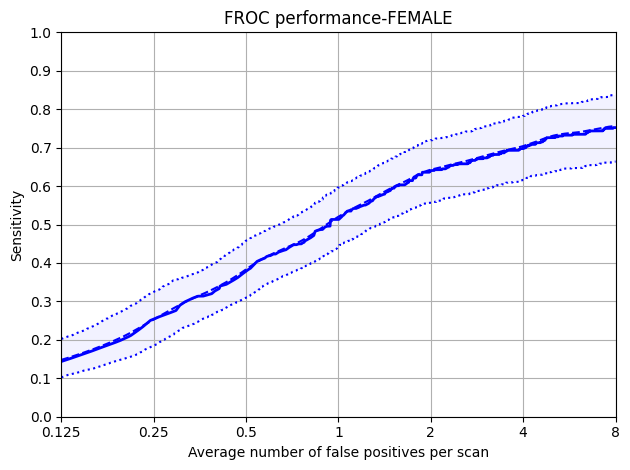

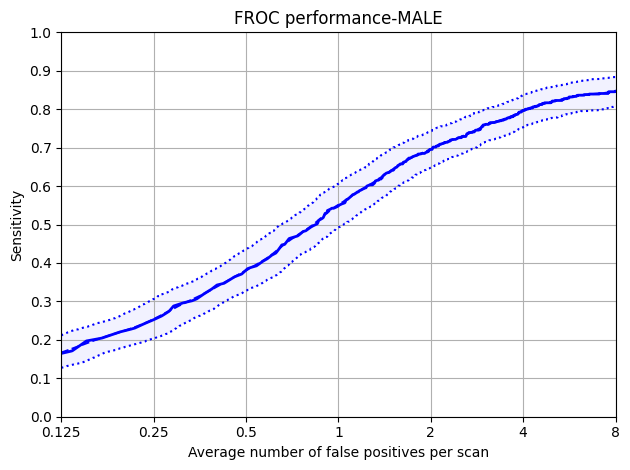

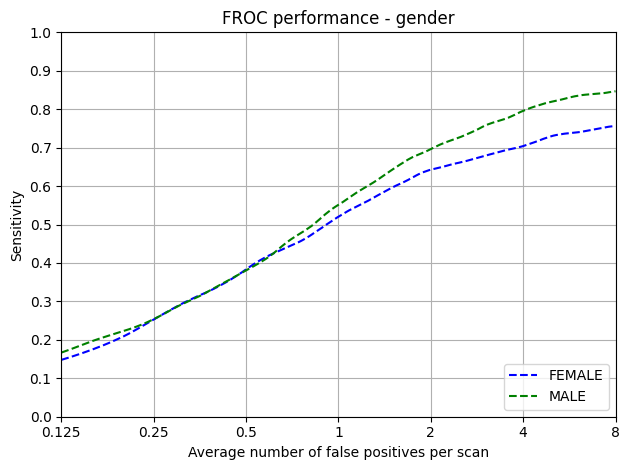

In [7]:
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/annotations.csv')

predictions = pd.read_csv(predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

## Ethnicity Analysis

/tmp/tmp0npdk9eq/annotations.csv
Total number of included nodule annotations: 18
Total number of nodule annotations: 18
Cases: 21


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 1295.48it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.02,0.00,0.12
159,0.25,0.05,0.00,0.24
476,0.50,0.17,0.00,0.50
1111,1.00,0.53,0.22,0.93
2381,2.00,0.81,0.59,1.00
4920,4.00,0.83,0.61,1.00
9999,8.00,0.92,0.73,1.00


Mean Sensitivity: 0.48 Low Sensitivity: 0.31 High Sensitivity: 0.68


,True positives,18
0,False positives,957.000
1,False negatives,0.000
2,True negatives,0.000
3,Total number of candidates,1011.000
4,Total number of nodules,18.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,36.000
7,Sensitivity,1.000
8,Average number of candidates per scan,48.143


/tmp/tmpo0su964n/annotations.csv
Total number of included nodule annotations: 852
Total number of nodule annotations: 852
Cases: 660
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-4739-xfy_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlappi

100%|██████████| 1000/1000 [00:23<00:00, 41.83it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.16,0.13,0.21
159,0.25,0.26,0.21,0.30
476,0.50,0.37,0.33,0.42
1111,1.00,0.52,0.47,0.58
2381,2.00,0.67,0.62,0.72
4920,4.00,0.75,0.71,0.79
9999,8.00,0.81,0.77,0.85


Mean Sensitivity: 0.51 Low Sensitivity: 0.46 High Sensitivity: 0.55


,True positives,726
0,False positives,34035.000
1,False negatives,126.000
2,True negatives,0.000
3,Total number of candidates,35504.000
4,Total number of nodules,852.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,753.000
7,Sensitivity,0.852
8,Average number of candidates per scan,53.794


/tmp/tmpxusw5lh7/annotations.csv
Total number of included nodule annotations: 71
Total number of nodule annotations: 71
Cases: 66


100%|██████████| 1000/1000 [00:01<00:00, 650.24it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.23,0.06,0.50
159,0.25,0.37,0.13,0.63
476,0.50,0.47,0.19,0.74
1111,1.00,0.57,0.24,0.88
2381,2.00,0.63,0.27,0.95
4920,4.00,0.66,0.29,0.96
9999,8.00,0.66,0.29,0.97


Mean Sensitivity: 0.51 Low Sensitivity: 0.21 High Sensitivity: 0.8


,True positives,47
0,False positives,2400.000
1,False negatives,24.000
2,True negatives,0.000
3,Total number of candidates,2490.000
4,Total number of nodules,71.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,43.000
7,Sensitivity,0.662
8,Average number of candidates per scan,37.727


/tmp/tmpkvoodqdn/annotations.csv
Total number of included nodule annotations: 147
Total number of nodule annotations: 147
Cases: 117


100%|██████████| 1000/1000 [00:03<00:00, 317.03it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.13,0.07,0.20
159,0.25,0.20,0.12,0.31
476,0.50,0.35,0.25,0.47
1111,1.00,0.52,0.43,0.62
2381,2.00,0.67,0.57,0.75
4920,4.00,0.79,0.68,0.88
9999,8.00,0.83,0.72,0.93


Mean Sensitivity: 0.5 Low Sensitivity: 0.41 High Sensitivity: 0.59


,True positives,125
0,False positives,5300.000
1,False negatives,22.000
2,True negatives,0.000
3,Total number of candidates,5560.000
4,Total number of nodules,147.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,135.000
7,Sensitivity,0.850
8,Average number of candidates per scan,47.521


/tmp/tmp2cnj2tga/annotations.csv
Total number of included nodule annotations: 28
Total number of nodule annotations: 28
Cases: 32


100%|██████████| 1000/1000 [00:00<00:00, 1004.70it/s]


,fps,mean_sens,low_sens,high_sens
0,0.12,0.24,0.07,0.55
159,0.25,0.41,0.13,0.75
476,0.50,0.63,0.38,0.87
1111,1.00,0.80,0.61,0.94
2381,2.00,0.87,0.71,1.00
4920,4.00,0.95,0.86,1.00
9999,8.00,0.96,0.88,1.00


Mean Sensitivity: 0.69 Low Sensitivity: 0.52 High Sensitivity: 0.87


,True positives,28
0,False positives,1370.000
1,False negatives,0.000
2,True negatives,0.000
3,Total number of candidates,1430.000
4,Total number of nodules,28.000
5,Ignored candidates on excluded nodules,0.000
6,Ignored candidates which were double detec...,32.000
7,Sensitivity,1.000
8,Average number of candidates per scan,44.688


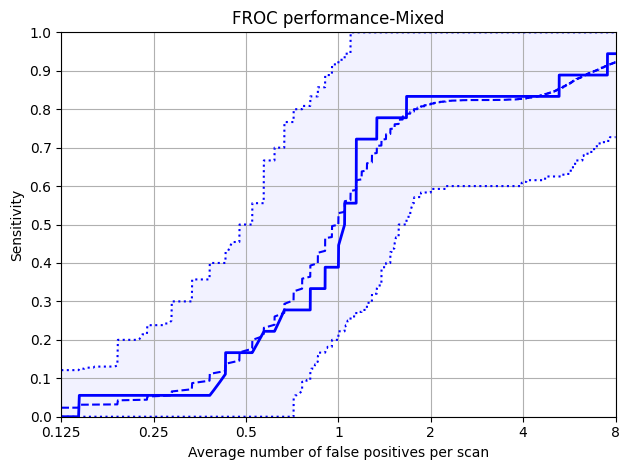

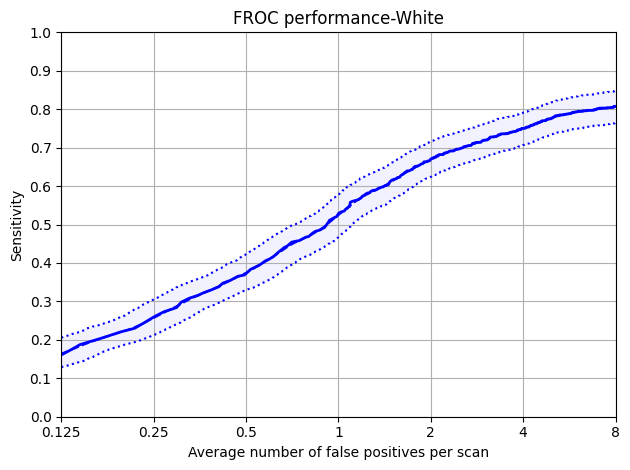

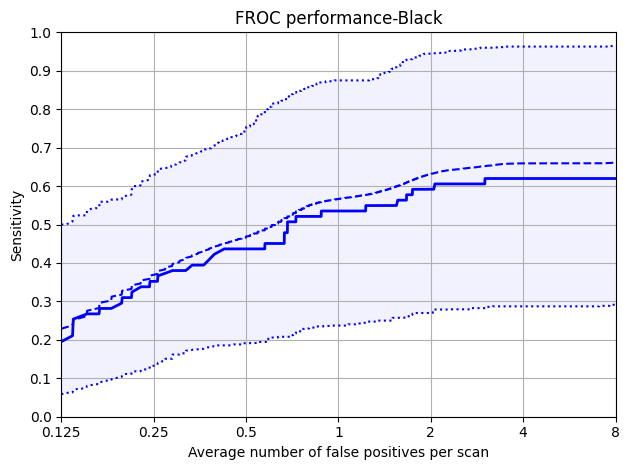

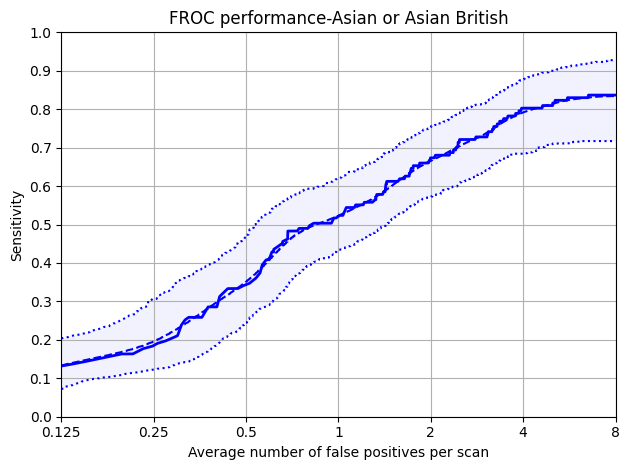

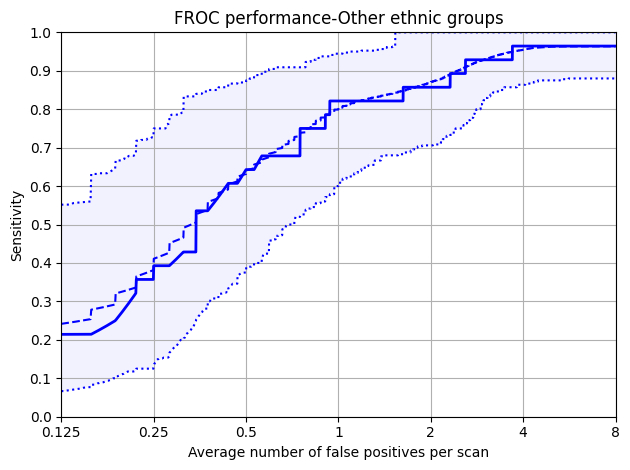

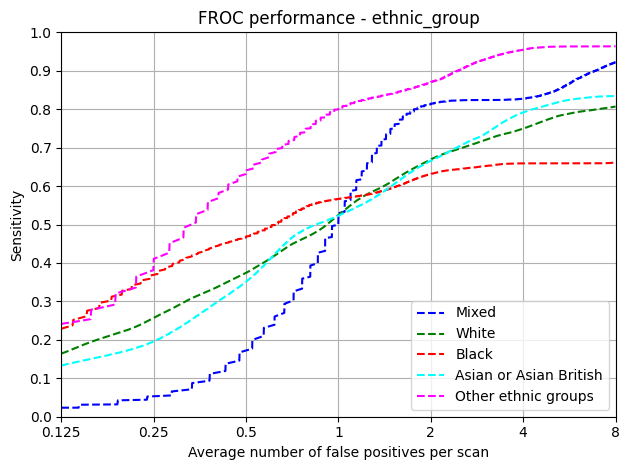

In [8]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/partial/{protected_group}'
)

# False Positive and Miss Investigations

The Sensitivity is very low at the lowest FPPS rate. This is contra to published results on LUNA, although LUNA does use an exclusions criteria which adjusts the FROC curve up.

Although the ablation study on LUNA showed the drop offs due to the change in parameters i.e., removing exclusion criteria, nodules &lt;4mm from training etc. it didn't go into details as to what scans were being missed at each of the FPPS rates

This investigation attempts to tease out what is missed at each operating poiint to see if there are any patterns, which in turn may inform how best to train the model for optimal results.

In [45]:
def get_thresholds(analysis_data):
    """
    Get the thresholds at different FPPs

    Args:
    analysis_data: tuple, tuple of fps, sens, threshold

    Returns:
    thresh_values: list of float, list of thresholds at different FPPs

    """
    fps = analysis_data[0]
    sens = analysis_data[1]
    threshold = analysis_data[2]

    idxs = []
    fps_values = []
    sens_values = []
    thresh_values = []
    for fpps in [0.125, 0.25, 0.5, 1, 2, 4, 8]:

        idx = np.abs(fps - fpps).argmin()
        idxs.append(idx)
        fps_values.append(fps[idx])
        sens_values.append(sens[idx])
        thresh_values.append(threshold[idx])

    return thresh_values

def miss_anaysis_at_fpps(scans_path, annotations_path, exclusions_path, predictions_path, thresholds):
    """
    Get the missed annotations at different FPPs

    Args:
    scans_path: str, path to the scans csv
    annotations_path: str, path to the annotations csv
    exclusions_path: str, path to the exclusions csv
    predictions_path: str, path to the predictions csv
    thresholds: list of float, list of thresholds to evaluate

    Returns:
    missed_metadata: list of pd.DataFrame, list of missed annotations at each threshold

    """

    missed_metadata = []
    for threshold in thresholds:
        predictions = pd.read_csv(predictions_path)
        predictions_at_operating_point = predictions[predictions.threshold > threshold]

        with TemporaryDirectory() as temp_dir:
            predictions_at_operating_point.to_csv(f'{temp_dir}/predictions.csv', index=False)
            missed_annotations = noduleCADEvaluation(
                annotations_filename=annotations_path,
                annotations_excluded_filename=exclusions_path,
                seriesuids_filename=scans_path,
                results_filename=f'{temp_dir}/predictions.csv',
                filter='Missed Annotations',
                outputDir=f'{temp_dir}/results',
                perform_bootstrapping=False,
                show_froc=False
            )

            misses = (
                pd.read_csv(
                f'{temp_dir}/results/nodulesWithoutCandidate_predictions.txt',
                header=None
                )
                .rename(columns={0:'name',1: 'idx', 2:'col',3:'row',4:'index',5:'diameter',6:'threshold'})
                .assign(miss=True)
            )
            annotations = pd.read_csv(annotations_path)

            merge_keys = ['name','row','col','index','diameter']

            # display(misses[merge_keys].sort_values('name').head(10))
            # display(annotations[merge_keys].sort_values('name').head(10))

            df = pd.merge(misses, annotations, on=merge_keys)
            print(f'Missed Annotations at {threshold} FPPs:', len(df))
            missed_metadata.append(df)

    return missed_metadata

def false_positive_analysis(thresholds):
    """
    Get the false positives at different thresholds
    
    Args:
    thresholds: list of float, list of thresholds to evaluate
    
    Returns:
    false_positives: list of pd.DataFrame, list of false positives at each threshold
    """
    for threshold in thresholds:

        predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv')
        predictions = predictions[predictions['threshold'] > threshold]


thresholds = get_thresholds(grt123_summit_summit)
missed_metadata = miss_anaysis_at_fpps(
    scans_path=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    annotations_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    predictions_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv',
    thresholds=thresholds
)

/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
Missed Annotations at 7.4244456 FPPs: 943
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
Missed Annotations at 7.044227 FPPs: 872
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116
Total number of nodule annotations: 1116
Cases: 892
Missed Annotations at 6.623532 FPPs: 768
/home/jmccabe/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv
Total number of included nodule annotations: 1116


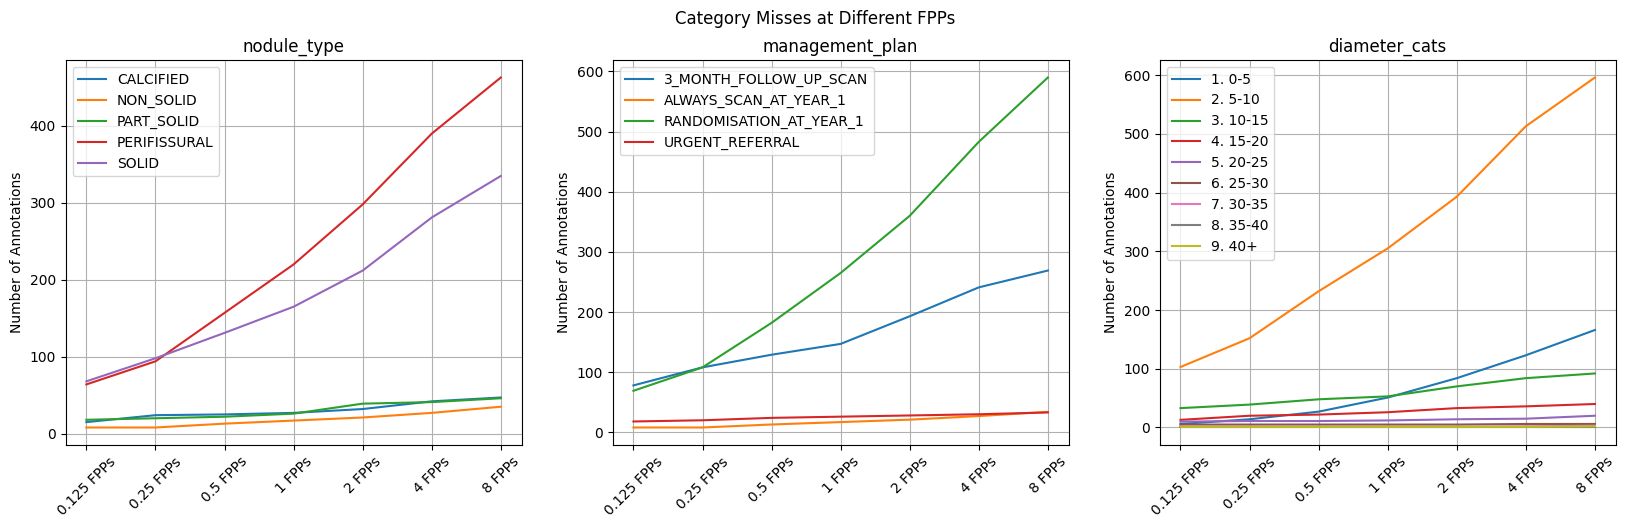

In [103]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for ivx, var in enumerate(['nodule_type','management_plan','diameter_cats']):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv')
    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []
    for idx, metadata in enumerate(missed_metadata):
        vc = metadata[var].value_counts().sort_index()

        results.append((total_vc - vc).rename(f'{operating_points[idx]} FPPs'))

    df = pd.concat(results, axis=1).fillna(0).round(2)

    for column in df.T:
        ax[ivx].plot(df.T[column], label=column)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('Number of Annotations')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Misses at Different FPPs')
plt.show()

In [102]:
# False Positive Analysis

def is_match(annotation, prediction):
    """
    Check if the annotation and prediction are a match

    Args:
    annotation: pd.Series, annotation
    prediction: pd.Series, prediction

    Returns:
    bool, True if the annotation and prediction are a match
    """
    x = float(annotation['row'])
    y = float(annotation['col'])
    z = float(annotation['index'])
    d = float(annotation['diameter'])
    radiusSquared = pow((d / 2.0), 2.0)
    dx = float(prediction['row'])
    dy = float(prediction['col'])
    dz = float(prediction['index'])
    distanceSquared = pow((dx - x), 2.0) + pow((dy - y), 2.0) + pow((dz - z), 2.0)
    return distanceSquared <= radiusSquared

def false_positive_analysis(thresholds, predictions, annotations):
    """
    Get the false positives at different thresholds

    Args:
    thresholds: list of float, list of thresholds to evaluate
    predictions: pd.DataFrame, dataframe of predictions
    annotations: pd.DataFrame, dataframe of annotations

    Returns:
    false_postives_fpps: dict, dict of false positives at each threshold
    """

    false_postives_fpps = {}
    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']
    for tdx, threshold in enumerate(thresholds):

        threshold_predictions = predictions[predictions['threshold'] > threshold]

        print('predictions:', len(threshold_predictions), 'at threshold:', threshold)

        false_positives = {}
        for name in predictions['name'].unique():
            
            temp_annotations = annotations[annotations['name'] == name]
            temp_predictions = threshold_predictions[threshold_predictions['name'] == name]

            for pdx, prediction in temp_predictions.iterrows():
                false_positives[pdx] = False
                for adx, annotation in temp_annotations.iterrows():
                    if is_match(annotation, prediction):
                        false_positives[pdx] = True



        print('false positives:', sum(pd.Series(false_positives)), 'at threshold:', threshold)
        threshold_predictions['false_positive'] = false_positives
        false_postives_fpps[operating_points[tdx]] = threshold_predictions
            
                
    return false_postives_fpps

thresholds = get_thresholds(grt123_summit_summit)

scans = pd.read_csv(f'{workspace_path}/metadata/summit/partial/test_scans.csv')
predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_predictions.csv')
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/partial/partial_metadata.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,
    
    predictions=predictions,
    annotations=annotations
)

false_positives_fpps['0.125'].head(10)


predictions: 283 at threshold: 7.4244456
false positives: 173 at threshold: 7.4244456
predictions: 468 at threshold: 7.044227
false positives: 244 at threshold: 7.044227
predictions: 792 at threshold: 6.623532
false positives: 348 at threshold: 6.623532
predictions: 1348 at threshold: 6.0737205
false positives: 455 at threshold: 6.0737205
predictions: 2381 at threshold: 5.2962136
false positives: 604 at threshold: 5.2962136
predictions: 4353 at threshold: 4.0496693
false positives: 783 at threshold: 4.0496693
predictions: 8091 at threshold: 2.1779246
false positives: 929 at threshold: 2.1779246


,threshold,index,row,col,diameter,name,false_positive
51,7.595308,155.877170,128.381530,212.688280,4.690072,summit-2225-stn_Y0_BASELINE_A,True
105,7.715776,108.368740,116.909490,70.699020,5.478899,summit-2252-etc_Y0_BASELINE_A,True
357,7.711990,59.935630,128.626450,296.710100,4.664363,summit-2336-efe_Y0_BASELINE_A,True
492,7.659008,190.721970,140.990450,46.258354,5.038538,summit-2346-rhj_Y0_BASELINE_A,True
543,7.574071,141.857270,34.681793,70.475150,4.185863,summit-2347-mfb_Y0_BASELINE_A,True
715,7.609250,36.213223,132.798970,114.342705,5.214329,summit-2365-azk_Y0_BASELINE_A,False
806,7.929482,70.212060,110.530860,12.567449,5.829917,summit-2383-mff_Y0_BASELINE_A,True
807,7.622412,69.778850,136.918290,278.497900,4.662397,summit-2383-mff_Y0_BASELINE_A,True
922,7.702776,72.423690,49.015068,256.852660,8.745585,summit-2429-gfd_Y0_BASELINE_A,False
991,7.513833,46.404953,60.934030,233.016770,9.738584,summit-2449-byz_Y0_BASELINE_A,False
